#### 何数学

# > Part1：解析MNIST数据集 
* 参考 https://www.jianshu.com/p/84f72791806f

In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from matplotlib import cm
from sklearn.manifold import TSNE 
import os

%matplotlib inline

In [2]:
# 训练集文件
train_images_idx3_ubyte_file = 'E:/0yanjiusheng/2AIML/Homework4/train-images.idx3-ubyte'
# 训练集标签文件
train_labels_idx1_ubyte_file = 'E:/0yanjiusheng/2AIML/Homework4/train-labels.idx1-ubyte'

# 测试集文件
test_images_idx3_ubyte_file = 'E:/0yanjiusheng/2AIML/Homework4/t10k-images.idx3-ubyte'
# 测试集标签文件
test_labels_idx1_ubyte_file = 'E:/0yanjiusheng/2AIML/Homework4/t10k-labels.idx1-ubyte'

In [3]:
def decode_idx3_ubyte(idx3_ubyte_file):
    """
    解析idx3文件的通用函数
    :param idx3_ubyte_file: idx3文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx3_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数、图片数量、每张图片高、每张图片宽
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print ('魔数:%d, 图片数量: %d张, 图片大小: %d*%d' % (magic_number, num_images, num_rows, num_cols))

    # 解析数据集
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print ('已解析 %d' % (i + 1) + '张')
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images

In [4]:
def decode_idx1_ubyte(idx1_ubyte_file):
    """
    解析idx1文件的通用函数
    :param idx1_ubyte_file: idx1文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx1_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数和标签数
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print ('魔数:%d, 图片数量: %d张' % (magic_number, num_images))

    # 解析数据集
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print ('已解析 %d' % (i + 1) + '张')
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels

In [5]:
def load_train_images(idx_ubyte_file=train_images_idx3_ubyte_file):
    """
    :param idx_ubyte_file: idx文件路径
    :return: n*row*col维np.array对象，n为图片数量
    """
    return decode_idx3_ubyte(idx_ubyte_file)
def load_train_labels(idx_ubyte_file=train_labels_idx1_ubyte_file):
    """
    :param idx_ubyte_file: idx文件路径
    :return: n*1维np.array对象，n为图片数量
    """
    return decode_idx1_ubyte(idx_ubyte_file)


def load_test_images(idx_ubyte_file=test_images_idx3_ubyte_file):
    """
    :param idx_ubyte_file: idx文件路径
    :return: n*row*col维np.array对象，n为图片数量
    """
    return decode_idx3_ubyte(idx_ubyte_file)


def load_test_labels(idx_ubyte_file=test_labels_idx1_ubyte_file):
    """
    :param idx_ubyte_file: idx文件路径
    :return: n*1维np.array对象，n为图片数量
    """
    return decode_idx1_ubyte(idx_ubyte_file)

魔数:2051, 图片数量: 60000张, 图片大小: 28*28
已解析 10000张
已解析 20000张
已解析 30000张
已解析 40000张
已解析 50000张
已解析 60000张
魔数:2049, 图片数量: 60000张
已解析 10000张
已解析 20000张
已解析 30000张
已解析 40000张
已解析 50000张
已解析 60000张
魔数:2051, 图片数量: 10000张, 图片大小: 28*28
已解析 10000张
魔数:2049, 图片数量: 10000张
已解析 10000张
👇 label: 5


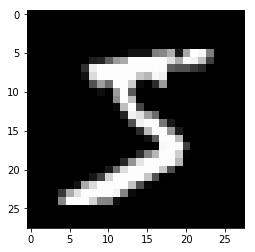

👇 label: 0


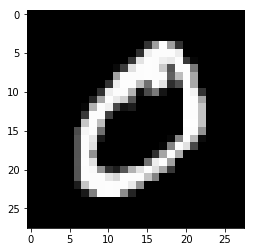

👇 label: 4


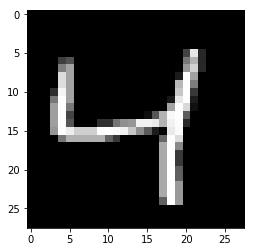

👇 label: 1


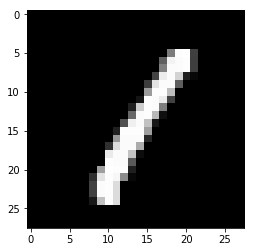

👇 label: 9


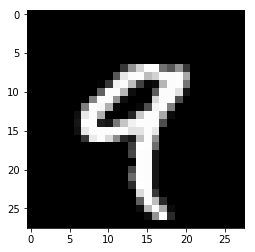

done


In [6]:
# 加载数据，并转化为tensor
train_images = torch.tensor(load_train_images(), dtype=torch.float32) 
train_labels = torch.tensor(load_train_labels(), dtype=torch.float32)
test_images = torch.tensor(load_test_images(), dtype=torch.float32)
test_labels = torch.tensor(load_test_labels(), dtype=torch.float32)

# 查看前5个数据及其标签以读取是否正确
for i in range(5):
    print ('👇 label:',int(train_labels[i]))
    plt.imshow(train_images[i], cmap='gray')
    plt.show()
print ('done')

In [7]:
print(train_images[0][5]) # 打印第一张图的第六行，可以看到每个像素点取值范围在0~255，因此需要normalize到0~1之间

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          3.,  18.,  18.,  18., 126., 136., 175.,  26., 166., 255., 247., 127.,
          0.,   0.,   0.,   0.])


In [8]:
# 标准化到0~1之间（由于最小值为0，因此直接除以最大值）
train_images = train_images / train_images.max()
test_images = test_images / test_images.max()

# > Part2：Auto-encoder
* **1. 基础AE：基于线性层的自编码器**
* **2. CAE：卷积自编码器**
* **3. CVAE：条件变分自编码器**

## 2.1 基础AE：基于线性层的AutoEncoder

In [9]:
# 超参数设置
EPOCH = 20
BATCH_SIZE = 100
LR = 0.005     # 学习率
VIEW_IMG = 6 # 训练过程中用来展示效果的图片数量

In [10]:
# 建立Data Loader
dataset = Data.TensorDataset(train_images, train_labels)
train_loader = Data.DataLoader(dataset = dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = Data.TensorDataset(test_images, test_labels)
test_loader = Data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False) # 不打乱

In [11]:
# 设置随机种子
seed = 1
torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)   # 为所有GPU设置随机种子

In [12]:
# 定义网络结构
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 12),  
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 压缩至0-1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)
Epoch 1 Step 300 ; Training loss: 0.06286
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


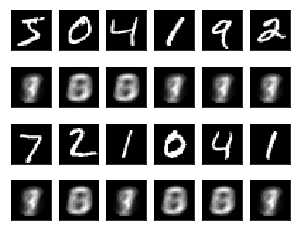

Epoch 1 Step 600 ; Training loss: 0.05340
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


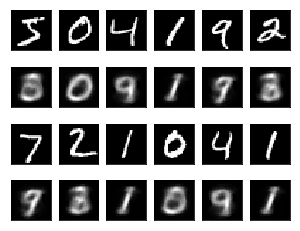

Epoch 5 Step 300 ; Training loss: 0.03581
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


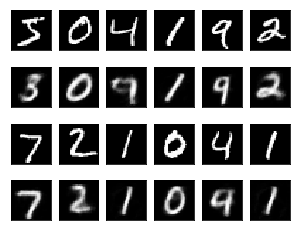

Epoch 5 Step 600 ; Training loss: 0.03512
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


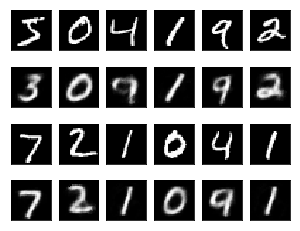

Epoch 10 Step 300 ; Training loss: 0.02908
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


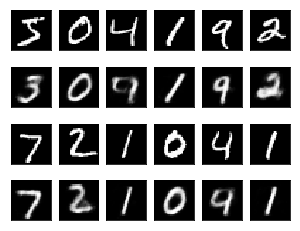

Epoch 10 Step 600 ; Training loss: 0.02604
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


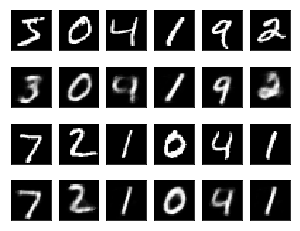

Epoch 15 Step 300 ; Training loss: 0.02317
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


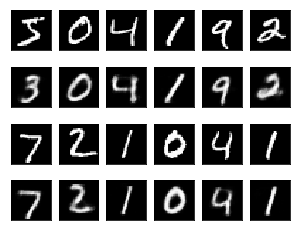

Epoch 15 Step 600 ; Training loss: 0.02294
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


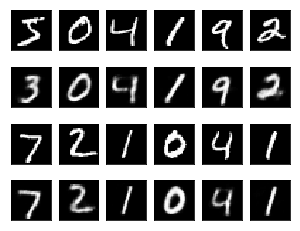

Epoch 20 Step 300 ; Training loss: 0.02303
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


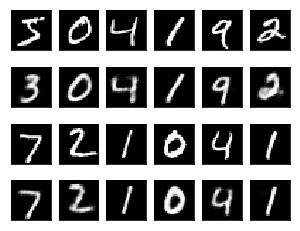

Epoch 20 Step 600 ; Training loss: 0.02142
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


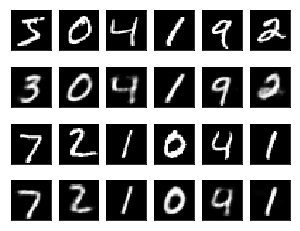

In [13]:
autoencoder = AutoEncoder()
autoencoder.cuda()

print(autoencoder)

optimizer = optim.Adam(autoencoder.parameters(), lr=LR)
cal_loss = nn.MSELoss()

# 训练过程中用来展示效果的图片
view_img_train = Variable(train_images[:VIEW_IMG].view(-1, 28*28).type(torch.FloatTensor)).cuda()
view_img_test = Variable(test_images[:VIEW_IMG].view(-1, 28*28).type(torch.FloatTensor)).cuda()

for epoch in range(EPOCH):
    for step, (image, label) in enumerate(train_loader):
        
        # 变量
        batch_x = Variable(image.view(-1, 28*28)).cuda()   
        batch_y = Variable(image.view(-1, 28*28)).cuda()  
        batch_label = Variable(label).cuda()              
        
        # 训练
        encoded, decoded = autoencoder(batch_x)
        loss = cal_loss(decoded, batch_y)      
        optimizer.zero_grad()             
        loss.backward()                    
        optimizer.step()                  
        
        # 训练过程可视化
        if (step+1) % 300 == 0 and epoch in [0, 4, 9, 14, 19]:  # 一批训练数据为60000，batch_size为100，共600批（step=599）
            print('Epoch', epoch+1,'Step', step+1, '; Training loss: %.5f' % loss.item())
            print('从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图')

            # 用来展示训练效果的重构结果
            _, decoded_train = autoencoder(view_img_train)
            _, decoded_test = autoencoder(view_img_test)

            f, a = plt.subplots(4, VIEW_IMG, figsize=(5, 4))
            
            for i in range(VIEW_IMG):
                a[0][i].imshow(np.reshape(view_img_train.cpu().data.numpy()[i], (28, 28)), cmap='gray')
                a[0][i].set_xticks(()); a[0][i].set_yticks(()) # 去除图的刻度 
                a[1][i].imshow(np.reshape(decoded_train.cpu().data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())  
                a[2][i].imshow(np.reshape(view_img_test.cpu().data.numpy()[i], (28, 28)), cmap='gray')
                a[2][i].set_xticks(()); a[2][i].set_yticks(())
                a[3][i].imshow(np.reshape(decoded_test.cpu().data.numpy()[i], (28, 28)), cmap='gray')
                a[3][i].set_xticks(()); a[3][i].set_yticks(())
            plt.show(); 
            
            print('=' * 70)

###  >> 对于测试集的最后1000张图片，对其二维的隐变量进行可视化

In [14]:
# 对于测试集的最后1000张图片，对其12维的隐变量用t-SNE降至两维，进行可视化

# 计算隐空间中的向量并转成array
saved_latent_code, _ = autoencoder(test_images[-1000:].view(-1, 28*28).cuda() ) 
saved_latent_code = saved_latent_code.cpu().detach().numpy() 

# 降维
tsne = TSNE(n_components=2, random_state=0)
latent_code_2d = tsne.fit_transform(saved_latent_code)

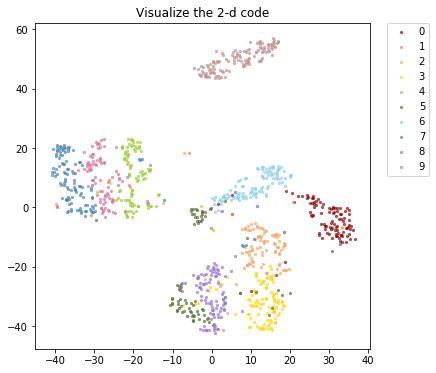

In [16]:
# 画图
color_list = ['darkred', 'rosybrown', 'sandybrown', 'gold', 'yellowgreen',
               'darkolivegreen', 'skyblue', 'steelblue', 'mediumpurple','palevioletred']

plt.figure(figsize = (6,6))
for number in range(10):
    flag = (test_labels[-1000:].numpy() == number)
    plt.scatter(latent_code_2d[flag,0],
                latent_code_2d[flag,1],
                c = color_list[number], s = 5, label = number, alpha = 0.6)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.title('Visualize the 2-d code')
plt.show()

#### 可见，大部分数字区分较好，但是5与8有较多杂糅，也与3有些交叉。

## 2.2 CAE：卷积自编码器 Convolutional Autoencoder

In [17]:
# 超参数设置
EPOCH = 8
BATCH_SIZE = 100
LR = 0.005     # 学习率
VIEW_IMG = 6 # 训练过程中用来展示效果的图片数量

In [18]:
# 建立Data Loader
train_dataset = Data.TensorDataset(train_images, train_labels)
train_loader = Data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = Data.TensorDataset(test_images, test_labels)
test_loader = Data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False) # 不打乱

In [19]:
# 设置随机种子
seed = 1
torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)   # 为所有GPU设置随机种子

In [21]:
# 定义网络结构

class AutoEncoder_cnn(nn.Module):
    
    def __init__(self):
        super(AutoEncoder_cnn, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3),
            # nn.Conv2d(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True))
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2),
            nn.ReLU(True),
            nn.Flatten(), # 拉直后维数为 32*4*4 = 512
            nn.Linear(512, 12)
        )
        self.Linear = nn.Linear(12, 512)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 5, stride=3),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        tmp_linear = self.Linear(encoded)
        decoded = self.decoder(tmp_linear.reshape(-1,32,4,4)) # 把拉直了的张量再变回去
        return encoded, decoded


AutoEncoder_cnn(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Flatten()
    (5): Linear(in_features=512, out_features=12, bias=True)
  )
  (Linear): Linear(in_features=12, out_features=512, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(3, 3))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)
Epoch 1 Step 300 ; Training loss: 0.02401
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


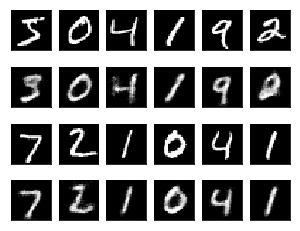

Epoch 1 Step 600 ; Training loss: 0.02036
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


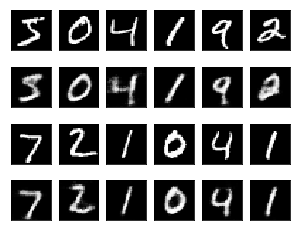

Epoch 2 Step 300 ; Training loss: 0.01883
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


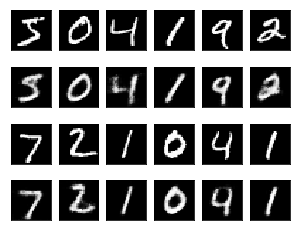

Epoch 2 Step 600 ; Training loss: 0.01781
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


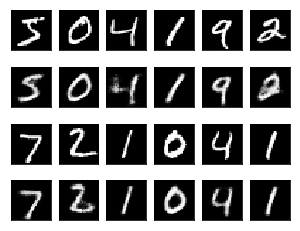

Epoch 3 Step 300 ; Training loss: 0.01639
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


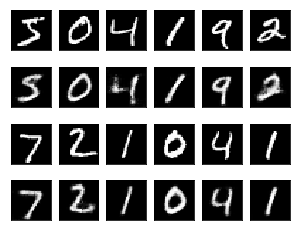

Epoch 3 Step 600 ; Training loss: 0.01565
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


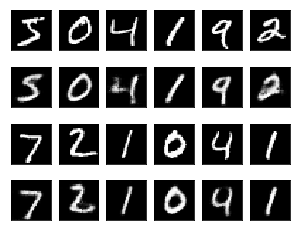

Epoch 4 Step 300 ; Training loss: 0.01411
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


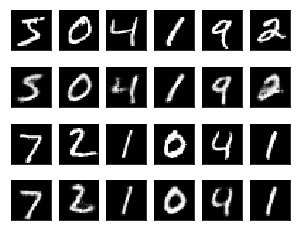

Epoch 4 Step 600 ; Training loss: 0.01606
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


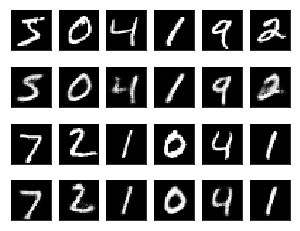

Epoch 5 Step 300 ; Training loss: 0.01440
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


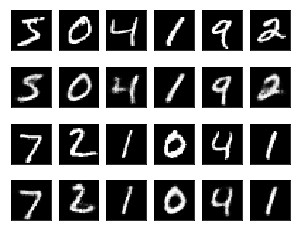

Epoch 5 Step 600 ; Training loss: 0.01442
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


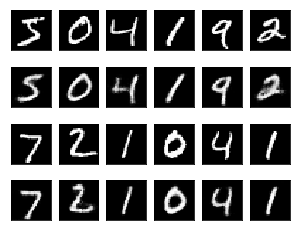

Epoch 6 Step 300 ; Training loss: 0.01503
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


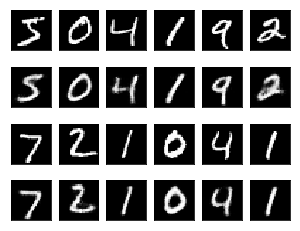

Epoch 6 Step 600 ; Training loss: 0.01396
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


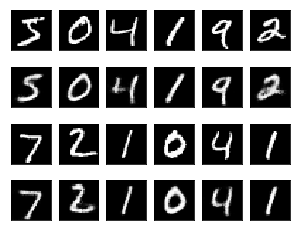

Epoch 7 Step 300 ; Training loss: 0.01463
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


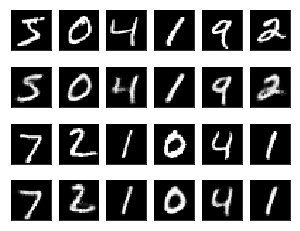

Epoch 7 Step 600 ; Training loss: 0.01384
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


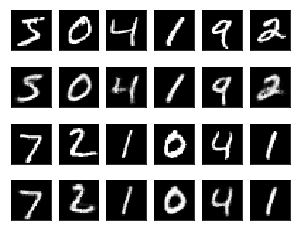

Epoch 8 Step 300 ; Training loss: 0.01468
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


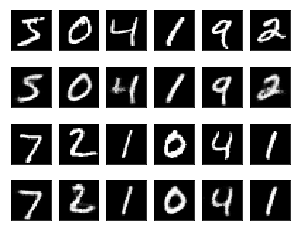

Epoch 8 Step 600 ; Training loss: 0.01475
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


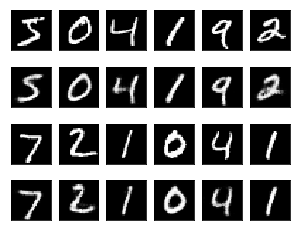

In [22]:
autoencoder_cnn = AutoEncoder_cnn()
autoencoder_cnn.cuda()

# 打印网络结构
print(autoencoder_cnn)
print('=' * 70)

optimizer = optim.Adam(autoencoder_cnn.parameters(), lr = LR)
cal_loss = nn.MSELoss()

# 训练过程中用来展示效果的图片
# .unsqueeze(1)是因为Conv2d layers接收的tensor形状是(n samples, channels, height, width) 
view_img_test = Variable(test_images[:VIEW_IMG].unsqueeze(1).type(torch.FloatTensor)).cuda() 
view_img_train = Variable(train_images[:VIEW_IMG].unsqueeze(1).type(torch.FloatTensor)).cuda() 

for epoch in range(EPOCH):
    for step, (image, label) in enumerate(train_loader):
        
        # 变量
        batch_x = Variable(image.unsqueeze(1)).cuda()   # .unsqueeze(1)是因为Conv2d layers接收的tensor形状是(n samples, channels, height, width) 
        batch_y = Variable(image.unsqueeze(1)).cuda()   
        batch_label = Variable(label).cuda()  
        
        # 训练
        encoded, decoded = autoencoder_cnn(batch_x)
        loss = cal_loss(decoded, batch_y)     
        optimizer.zero_grad()              
        loss.backward()                    
        optimizer.step()   
        
        # 训练过程可视化
        if  (step+1)%300 == 0: # 一批训练数据为60000，batch_size为100，共600批（step=599）

            print('Epoch', epoch+1, 'Step', step+1, '; Training loss: %.5f' % loss.item())
            print('从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图')
    
            # 用来展示训练效果的重构结果
            _, decoded_train = autoencoder_cnn(view_img_train) 
            _, decoded_test = autoencoder_cnn(view_img_test) 
                        
            f, a = plt.subplots(4, VIEW_IMG, figsize=(5, 4))
            
            for i in range(VIEW_IMG):
                a[0][i].imshow(np.reshape(view_img_train.cpu().data.numpy()[i], (28, 28)), cmap='gray')
                a[0][i].set_xticks(()); a[0][i].set_yticks(()) # 去除图的刻度 
                a[1][i].imshow(np.reshape(decoded_train.cpu().data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())  
                a[2][i].imshow(np.reshape(view_img_test.cpu().data.numpy()[i], (28, 28)), cmap='gray')
                a[2][i].set_xticks(()); a[2][i].set_yticks(())
                a[3][i].imshow(np.reshape(decoded_test.cpu().data.numpy()[i], (28, 28)), cmap='gray')
                a[3][i].set_xticks(()); a[3][i].set_yticks(())
            plt.show(); 
            
            print('=' * 70)

###  >> 对于测试集的最后1000张图片，对其二维的隐变量进行可视化

In [23]:
# 对于测试集的最后1000张图片，对其12维的隐变量用t-SNE降至两维，进行可视化

# 计算隐空间中的向量并转成array
saved_latent_code, _ = autoencoder_cnn(test_images[-1000:].unsqueeze(1).cuda()) 
saved_latent_code = saved_latent_code.cpu().detach().numpy() 

# 降维
tsne = TSNE(n_components=2, random_state=0)
latent_code_2d = tsne.fit_transform(saved_latent_code)

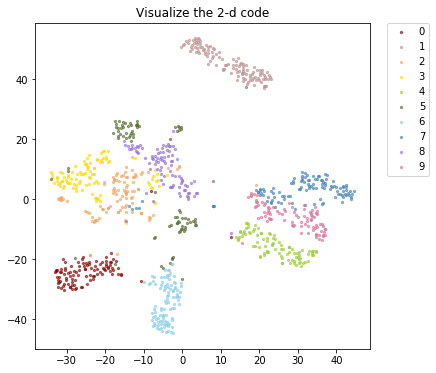

In [24]:
# 画图
color_list = ['darkred', 'rosybrown', 'sandybrown', 'gold', 'yellowgreen',
               'darkolivegreen', 'skyblue', 'steelblue', 'mediumpurple','palevioletred']

plt.figure(figsize = (6,6))
for number in range(10):
    flag = (test_labels[-1000:].numpy() == number)
    plt.scatter(latent_code_2d[flag,0],
                latent_code_2d[flag,1],
                c = color_list[number], s = 5, label = number, alpha = 0.6)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.title('Visualize the 2-d code')
plt.show()

#### 可见，大部分数字区分较好，但是5与8之间有杂糅，也与2和3有交叉。#### 

## 2.3 CVAE：条件变分自编码器 Conditional Variational AutoEncoder
* **加入标签信息辅助生成样本**
* **网络搭建参考 https://github.com/lyeoni/pytorch-mnist-CVAE/blob/master/pytorch-mnist-CVAE.ipynb**

In [143]:
# 建立Data Loader
train_dataset = Data.TensorDataset(train_images, train_labels)
train_loader = Data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = Data.TensorDataset(test_images, test_labels)
test_loader = Data.DataLoader(dataset = test_dataset, batch_size = 1000, shuffle = False) # 不打乱

In [144]:
# 模型搭建
class CVAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, c_dim): 
        # 其中 z 为隐变量维数，c 为标签的one-hot编码，dim为分别的维度
        super(CVAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim + c_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim + c_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
    
    def encoder(self, x, c):
        concat_input = torch.cat([x, c], 1)
        h = torch.relu(self.fc1(concat_input))
        h = torch.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)
    
    def sampling(self, mu, log_var): # 抽样
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) 
    
    def decoder(self, z, c): 
        concat_input = torch.cat([z, c], 1)
        h = torch.relu(self.fc4(concat_input))
        h = torch.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))
    
    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, 784), c)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c), mu, log_var, z


In [145]:
latent_dim = 12 # 隐空间编码维数为2
label_dim = train_labels.unique().size(0) # label维数（10）

cvae = CVAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=latent_dim, c_dim=label_dim) # 模型参数设置

if torch.cuda.is_available():
    cvae.cuda()

In [146]:
# 查看CVAE结构
cvae

CVAE(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=12, bias=True)
  (fc32): Linear(in_features=256, out_features=12, bias=True)
  (fc4): Linear(in_features=22, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [147]:
optimizer = optim.Adam(cvae.parameters())

# 损失函数 = reconstruction error + KL散度loss
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum') # reconstruction error
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # KL散度loss
    return BCE + KLD

# one-hot 编码
def one_hot(labels, class_size):  
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, int(label.item())] = 1 
    return Variable(targets)

In [148]:
# 定义训练集上训练
def train(epoch):
    cvae.train()
    train_loss = 0
    for step, (image, label) in enumerate(train_loader):
        image, label = image.cuda(), one_hot(label, label_dim).cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var, _ = cvae(image, label)
        loss = loss_function(recon_batch, image, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        # 训练过程监测
        if step in [0, 299, 599]:
            print('Epoch {} Step {}; Training loss: {:.2f}'.format(
                epoch+1, step+1, loss.item() / len(image)))
    print('—— Average trainging loss: {:.2f}'.format(train_loss / len(train_loader.dataset)))
    

In [149]:
# 定义测试集上测试
def test(save_latent_code = False):
    cvae.eval()
    test_loss= 0
    with torch.no_grad():
        for image, label in test_loader:
            image, label = image.cuda(), one_hot(label, label_dim).cuda()
            recon, mu, log_var, latent_code = cvae(image, label)
            test_loss += loss_function(recon, image, mu, log_var).item() 
        
    test_loss /= len(test_loader.dataset)
    print('—— Testing loss: {:.4f}'.format(test_loss))
    
    if save_latent_code == True: # 保存最后一千张图片对应的latent code
        return latent_code[-1000:].cpu().numpy() 

Epoch 1 Step 1; Training loss: 544.44
Epoch 1 Step 300; Training loss: 144.63
Epoch 1 Step 600; Training loss: 119.69
—— Average trainging loss: 157.50
—— Testing loss: 123.3213
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


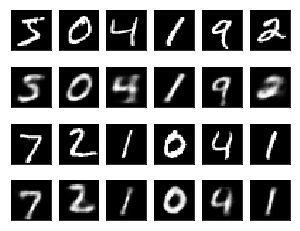

Epoch 2 Step 1; Training loss: 120.63
Epoch 2 Step 300; Training loss: 121.03
Epoch 2 Step 600; Training loss: 109.04
—— Average trainging loss: 117.52
—— Testing loss: 111.2288
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


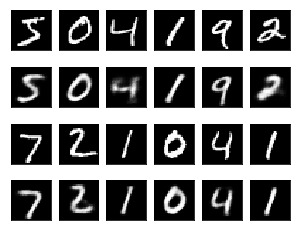

Epoch 3 Step 1; Training loss: 107.21
Epoch 3 Step 300; Training loss: 108.25
Epoch 3 Step 600; Training loss: 110.38
—— Average trainging loss: 109.63
—— Testing loss: 106.9011
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


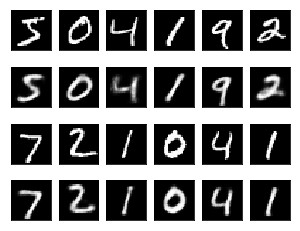

Epoch 4 Step 1; Training loss: 108.61
Epoch 4 Step 300; Training loss: 104.34
Epoch 4 Step 600; Training loss: 106.73
—— Average trainging loss: 105.86
—— Testing loss: 103.9482
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


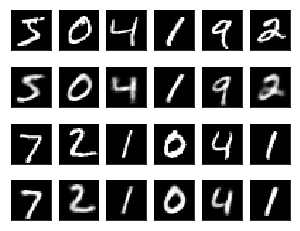

Epoch 5 Step 1; Training loss: 105.62
Epoch 5 Step 300; Training loss: 109.73
Epoch 5 Step 600; Training loss: 105.90
—— Average trainging loss: 103.57
—— Testing loss: 102.5010
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


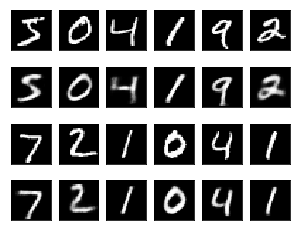

Epoch 6 Step 1; Training loss: 99.57
Epoch 6 Step 300; Training loss: 102.36
Epoch 6 Step 600; Training loss: 100.33
—— Average trainging loss: 101.99
—— Testing loss: 101.1774
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


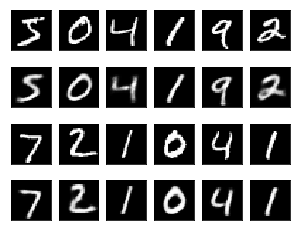

Epoch 7 Step 1; Training loss: 97.18
Epoch 7 Step 300; Training loss: 104.74
Epoch 7 Step 600; Training loss: 95.47
—— Average trainging loss: 100.73
—— Testing loss: 100.0688
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


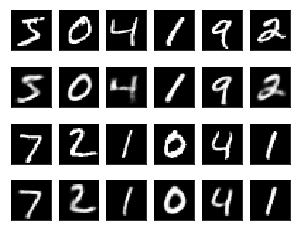

Epoch 8 Step 1; Training loss: 103.93
Epoch 8 Step 300; Training loss: 104.59
Epoch 8 Step 600; Training loss: 97.55
—— Average trainging loss: 99.75
—— Testing loss: 99.2786
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


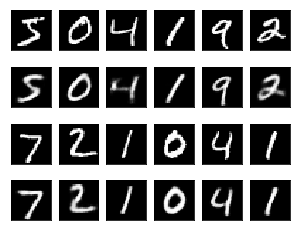

Epoch 9 Step 1; Training loss: 97.10
Epoch 9 Step 300; Training loss: 98.34
Epoch 9 Step 600; Training loss: 105.01
—— Average trainging loss: 98.98
—— Testing loss: 98.6345
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


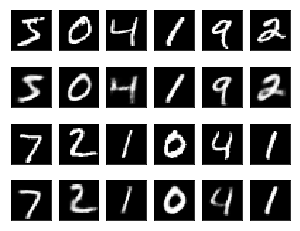

Epoch 10 Step 1; Training loss: 94.69
Epoch 10 Step 300; Training loss: 101.50
Epoch 10 Step 600; Training loss: 105.45
—— Average trainging loss: 98.32
—— Testing loss: 98.3864
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


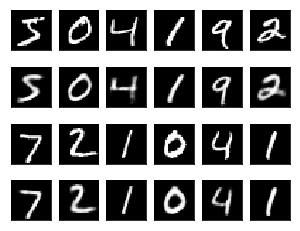

Epoch 11 Step 1; Training loss: 97.40
Epoch 11 Step 300; Training loss: 103.93
Epoch 11 Step 600; Training loss: 97.46
—— Average trainging loss: 97.72
—— Testing loss: 97.6193
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


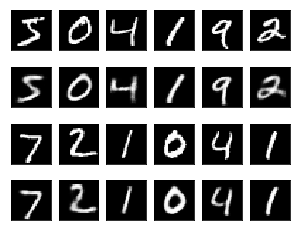

Epoch 12 Step 1; Training loss: 100.34
Epoch 12 Step 300; Training loss: 101.99
Epoch 12 Step 600; Training loss: 95.50
—— Average trainging loss: 97.25
—— Testing loss: 97.2982
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


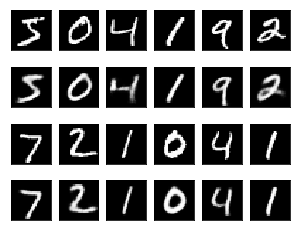

Epoch 13 Step 1; Training loss: 98.13
Epoch 13 Step 300; Training loss: 103.15
Epoch 13 Step 600; Training loss: 98.81
—— Average trainging loss: 96.77
—— Testing loss: 97.1463
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


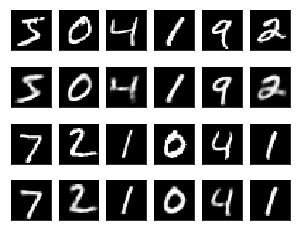

Epoch 14 Step 1; Training loss: 97.08
Epoch 14 Step 300; Training loss: 95.10
Epoch 14 Step 600; Training loss: 96.11
—— Average trainging loss: 96.40
—— Testing loss: 96.8313
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


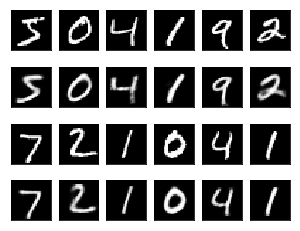

Epoch 15 Step 1; Training loss: 97.90
Epoch 15 Step 300; Training loss: 96.13
Epoch 15 Step 600; Training loss: 93.31
—— Average trainging loss: 96.13
—— Testing loss: 96.4338
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


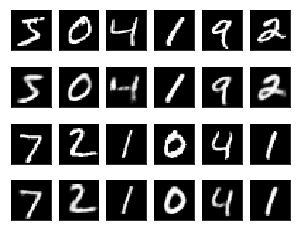

Epoch 16 Step 1; Training loss: 95.13
Epoch 16 Step 300; Training loss: 93.52
Epoch 16 Step 600; Training loss: 93.67
—— Average trainging loss: 95.77
—— Testing loss: 96.5480
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


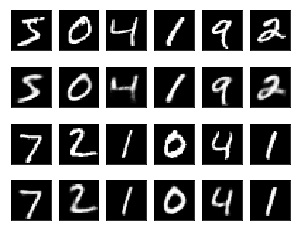

Epoch 17 Step 1; Training loss: 96.72
Epoch 17 Step 300; Training loss: 97.05
Epoch 17 Step 600; Training loss: 93.36
—— Average trainging loss: 95.51
—— Testing loss: 95.9929
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


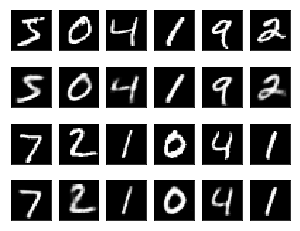

Epoch 18 Step 1; Training loss: 97.85
Epoch 18 Step 300; Training loss: 98.02
Epoch 18 Step 600; Training loss: 95.56
—— Average trainging loss: 95.26
—— Testing loss: 96.1079
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


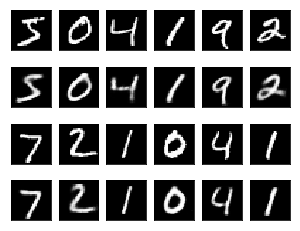

Epoch 19 Step 1; Training loss: 94.58
Epoch 19 Step 300; Training loss: 91.19
Epoch 19 Step 600; Training loss: 96.53
—— Average trainging loss: 95.03
—— Testing loss: 95.7761
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


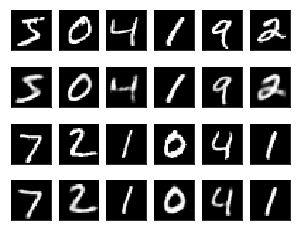

Epoch 20 Step 1; Training loss: 94.19
Epoch 20 Step 300; Training loss: 89.23
Epoch 20 Step 600; Training loss: 99.55
—— Average trainging loss: 94.80
—— Testing loss: 95.8332
从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图


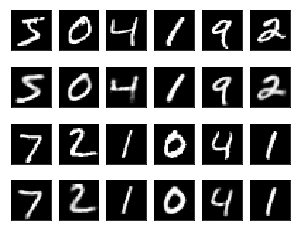

In [150]:
# 训练
EPOCH = 20

# 训练过程中用来展示效果的图片和标签（one-hot形式）
view_img_train = train_images[:VIEW_IMG].cuda()
view_label_train = one_hot(train_labels[:VIEW_IMG], label_dim).cuda()
view_img_test = test_images[:VIEW_IMG].cuda() 
view_label_test = one_hot(test_labels[:VIEW_IMG], label_dim).cuda()

for epoch in range(EPOCH):
    train(epoch)
  
    # 训练完毕后保存测试集最后一千张图对应的隐变量
    if epoch == EPOCH-1: 
        saved_latent_code = test(save_latent_code = True)
    else:
        test()
    
    # 用来展示训练效果的重构结果
    decoded_train, _, _, _ = cvae(view_img_train, view_label_train)
    decoded_test, _, _, _ = cvae(view_img_test, view_label_test)
          
    # 画图
    print('从上至下四行分别为：训练集中原图；训练集中编码解码后的图；测试集中原图；测试集中编码解码后的图')
    f, a = plt.subplots(4, VIEW_IMG, figsize=(5, 4))    
    for i in range(VIEW_IMG):
        a[0][i].imshow(np.reshape(view_img_train.cpu().data.numpy()[i], (28, 28)), cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(()) # 去除图的刻度 
        a[1][i].imshow(np.reshape(decoded_train.cpu().data.numpy()[i], (28, 28)), cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())  
        a[2][i].imshow(np.reshape(view_img_test.cpu().data.numpy()[i], (28, 28)), cmap='gray')
        a[2][i].set_xticks(()); a[2][i].set_yticks(())
        a[3][i].imshow(np.reshape(decoded_test.cpu().data.numpy()[i], (28, 28)), cmap='gray')
        a[3][i].set_xticks(()); a[3][i].set_yticks(())
    plt.show(); 
        
    print('='*70)

###  >> 对于测试集的最后1000张图片，对其二维的隐变量进行可视化

In [197]:
# 对于测试集的最后1000张图片，对其12维的隐变量用t-SNE降至两维，进行可视化

# 降维
tsne = TSNE(n_components=2, random_state=0)
latent_code_2d = tsne.fit_transform(saved_latent_code)

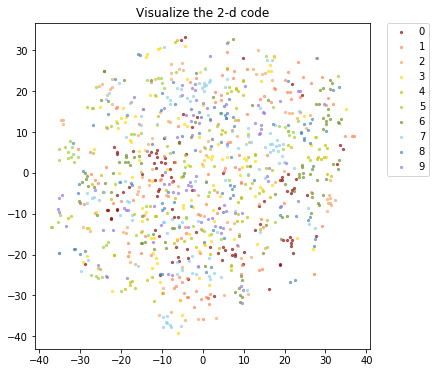

In [198]:
# 画图
color_list = ['darkred', 'coral', 'sandybrown', 'gold', 'y', 
              'yellowgreen', 'olivedrab', 'skyblue', 'steelblue', 'mediumpurple']

plt.figure(figsize = (6,6))
for number in range(label_dim):
    flag = (test_labels[-1000:].numpy() == number)
    plt.scatter(latent_code_2d[flag,0],
                latent_code_2d[flag,1],
                c = color_list[number], s = 5, label = number, alpha = 0.6)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.title('Visualize the 2-d code')
plt.show()

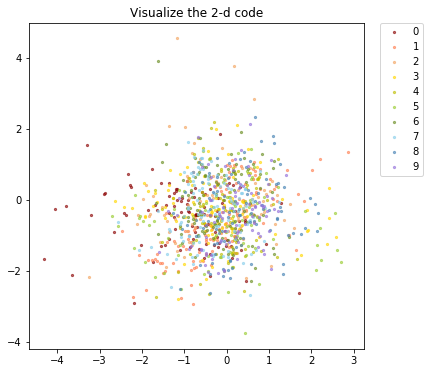

In [37]:
'''这是隐空间编码维度为2时（latent_dim = 2），编码直接可视化结果'''
# # 对于测试集的最后1000张图片，对其二维的隐变量进行可视化
# color_list = ['darkred', 'coral', 'sandybrown', 'gold', 'y', 
#               'yellowgreen', 'olivedrab', 'skyblue', 'steelblue', 'mediumpurple']

# plt.figure(figsize = (6,6))
# for number in range(label_dim):
#     flag = (test_labels[-1000:].numpy() == number)
#     plt.scatter(saved_latent_code[flag,0],
#                 saved_latent_code[flag,1],
#                 c = color_list[number], s = 5, label = number, alpha = 0.6)
# plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
# plt.title('Visualize the 2-d code')
# plt.show()

#### 由于CVAE的decoder生成图片时是基于隐空间的向量与标签的one-hot编码，因此分类的信息主要包含在了标签的one-hot编码中，隐空间二维向量倾向于遵循正态分布、并不包含清晰的分类信息，因此造成了上图各个数字点分布的杂糅。

### >> 由随机数抽样，产生新样本并保存图片

In [196]:
# 由随机数抽样，产生新样本并保存图片
import os

with torch.no_grad():
    z = torch.randn(20, latent_dim).cuda() # 抽取20组二维正态随机数
    c = torch.cat([torch.eye(10).cuda(),torch.eye(10).cuda()]) # 2个10x10的单位阵，即0-9的one-hot编码
    
    sample = cvae.decoder(z, c) # 按照0-10生成图片（两遍）
    
    # 保存图片
    if not os.path.exists('./samples/'):
        os.makedirs('./samples/')
    save_image(sample.view(20, 1, 28, 28), './samples/sample' + '.png')

隐空间编码维度为2时，生成的样本比较模糊，但比较鲁棒。
<img src='./samples/sample2.png'>

隐空间编码维度为12时，生成的样本比较清晰，但鲁棒性会有所下降。
<img src='./samples/sample12.png'>